In [ ]:
import vectorbt as vbt
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import logging
import pickle
from tqdm import tqdm




In [2]:

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

logging.info(f"Loading data")
data = pd.read_csv('data/btc.csv', index_col=0, parse_dates=True)

# just keep the 'Close' and 'Volume' columns
data = data[['Close', 'Volume']]


2023-03-20 17:54:19,910 - INFO - Loading data


In [3]:
# Create an indicator of the EMA of the close price
ema1_period = 20000
ema2_period = 5000
sma1_period = 10000
sma2_period = 1000
data.ta.ema(close='Close', length=ema1_period, append=True)
data.ta.ema(close='Close', length=ema2_period, append=True)
data.ta.sma(close='Close', length=sma1_period, append=True)
data.ta.sma(close='Close', length=sma2_period, append=True)
data.dropna(inplace=True)

forecast = 30
data['ema1_signal'] = (data['Close']/data[f'EMA_{ema1_period}'])-1
data['ema2_signal'] = (data['Close']/data[f'EMA_{ema2_period}'])-1
data['sma1_signal'] = (data['Close']/data[f'SMA_{sma1_period}'])-1
data['sma2_signal'] = (data['Close']/data[f'SMA_{sma2_period}'])-1

data[f'forecast_{forecast}'] = data['Close'].shift(-forecast).pct_change(forecast).dropna()
data['future'] = data['Close'].shift(-forecast)
data.dropna(inplace=True)

df = data.copy()
logging.info(f"Forecasting {forecast} mins fwd.")
logging.info(f'Using {ema1_period} and {ema2_period} ema periods')
logging.info(f'Using {sma1_period} and {sma2_period} sma periods')


2023-03-20 17:54:21,759 - INFO - Forecasting 30 mins fwd.
2023-03-20 17:54:21,760 - INFO - Using 20000 and 5000 ema periods
2023-03-20 17:54:21,760 - INFO - Using 10000 and 1000 sma periods


In [4]:
# Create the features (X) and target (y) data using numpy
X = df[['ema1_signal', 'ema2_signal', 'sma1_signal', 'sma2_signal', 'Volume']].iloc[:-forecast].values # signal and volume
y = df['Close'].pct_change(forecast).dropna().iloc[:-forecast].values.reshape(-1, 1) # future

# Split the data into training and testing sets and make sure they are the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Create the model and fit it to the data
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y.ravel())
logging.info(f"Model fitted")
y_val = df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
X_val = df[['ema1_signal', 'ema2_signal', 'sma1_signal', 'sma2_signal', 'Volume']][-len(y_val):] # signal and volume
y_val = y_val.values.reshape(-1, 1) # reshape to 2D
# make predictions
logging.info(f"Making predictions")
y_pred = model.predict(X_val.values)
logging.info(f"Predictions made")

# remove NaNs and infinities
valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_val.ravel()) # remove NaNs
y_pred = y_pred[valid_indices]
y_val = y_val[valid_indices]


2023-03-20 17:56:04,347 - INFO - Model fitted
2023-03-20 17:56:04,381 - INFO - Making predictions
2023-03-20 17:56:06,412 - INFO - Predictions made


In [5]:
def calculate_and_print_results(y_val, y_pred, threshold=0.0005):

    mse = mean_squared_error(y_pred, y_val)
    rmse = np.sqrt(mse)
    correct_predictions = np.abs(y_pred - y_val.ravel()) <= threshold
    direction_correct = (np.sign(y_pred) == np.sign(y_val.ravel())).astype(int)
    direction_accuracy = direction_correct.mean() * 100
    accuracy = np.mean(correct_predictions) * 100
    r2 = r2_score(y_val, y_pred)

    print(f"For a threshold of: {threshold}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse:.4f}")
    # print accuracy within 4 decimal places
    print(f"Accuracy: {accuracy:.4f}%")
    print(f"Direction Accuracy: {direction_accuracy:.4f}% This happened {direction_correct.sum()} times out of {len(direction_correct)}")
    print(f"R-squared: {r2:.4f}")
    results = {
        'mse': mse,
        'rmse': rmse,
        'accuracy': accuracy,
        'direction_accuracy': direction_accuracy,
        'r2': r2
    }
    return results

stats = calculate_and_print_results(y_val, y_pred, threshold=0.001)


For a threshold of: 0.001
MSE: 1.1840150881180445e-06
RMSE: 0.0011
Accuracy: 83.0634%
Direction Accuracy: 94.2566% This happened 530426 times out of 562747
R-squared: 0.9468


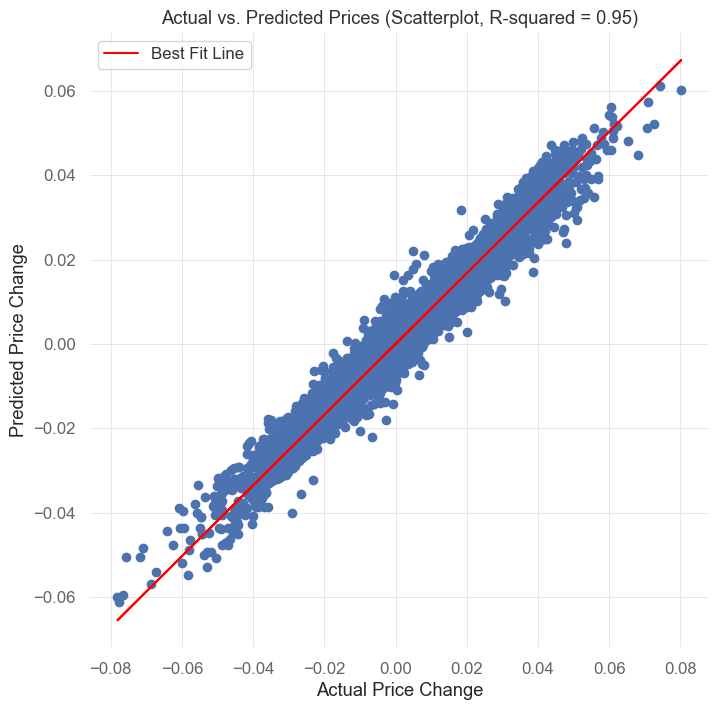

In [6]:
# Create a scatter plot of the predictions versus the actual values
def plot_scatter(y_val, y_pred, r2):

    # Fit a line of best fit to the data
    coeffs = np.polyfit(y_val.ravel(), y_pred.ravel(), 1)
    line = coeffs[0] * y_val.ravel() + coeffs[1]

    # Plot actual vs predicted prices as scatterplot
    plt.figure(figsize=(8, 8))
    plt.scatter(y_val, y_pred)
    plt.xlabel('Actual Price Change')
    plt.ylabel('Predicted Price Change')
    plt.title(f'Actual vs. Predicted Prices (Scatterplot, R-squared = {r2:.2f})')

    # Add best fit line
    plt.plot(y_val.ravel(), line, color='red', label='Best Fit Line')
    plt.legend()

    plt.show()

plot_scatter(y_val, y_pred, stats['r2'])

In [7]:
# Save the model
file_name = f'rf_model_ema{ema1_period}-ema{ema2_period}-sma{sma1_period}-sma{sma2_period}-f{forecast}.pkl'
with open(file_name,  'wb') as file:
    pickle.dump(model, file)

# Create a bunch of features using Pandas_TA

In [8]:
momo_bands_sma_ta = [
    {"kind":"sma", "length": 1000},
    {"kind":"sma", "length": 20000},
    {"kind":"ema", "length": 10000},
    {"kind":"ema", "length": 5000},
    {"kind":"bbands", "length": 2000, "ddof": 0},
    {"kind":"macd"},
    {"kind":"rsi"},
    {"kind":"log_return", "cumulative": True},
    {"kind":"sma", "close": "CUMLOGRET_1", "length": 50, "suffix": "CUMLOGRET"},
]
momo_bands_sma_strategy = ta.Strategy(
    "Momo, Bands, MAs and Cumulative Log Returns", # name
    momo_bands_sma_ta, # ta
    "MACD, RSI, Momo with BBANDS and EMAs, SMAs and Cumulative Log Returns" # description
)
momo_bands_sma_strategy

Strategy(name='Momo, Bands, MAs and Cumulative Log Returns', ta=[{'kind': 'sma', 'length': 1000}, {'kind': 'sma', 'length': 20000}, {'kind': 'ema', 'length': 10000}, {'kind': 'ema', 'length': 5000}, {'kind': 'bbands', 'length': 2000, 'ddof': 0}, {'kind': 'macd'}, {'kind': 'rsi'}, {'kind': 'log_return', 'cumulative': True}, {'kind': 'sma', 'close': 'CUMLOGRET_1', 'length': 50, 'suffix': 'CUMLOGRET'}], description='MACD, RSI, Momo with BBANDS and EMAs, SMAs and Cumulative Log Returns', created='Monday March 20, 2023, NYSE: 13:54:19, Local: 17:54:19 PDT, Day 79/365 (22.00%)')

In [10]:

data.ta.strategy(momo_bands_sma_strategy, append=True) # Add the new features to the dataframe
data.dropna(inplace=True)

In [17]:
forecast = 90 # minutes into the future to predict
df = data.copy()
cols = df.columns

# Create the features (X) and target (y) data using numpy
X = df[cols].iloc[:-forecast].values # signal and volume
y = df['Close'].pct_change(forecast).dropna().iloc[:-forecast].values.reshape(-1, 1) # future

# Split the data into training and testing sets and make sure they are the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Create the model and fit it to the data
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
chunk_size = 10000  # adjust this to a value that works for your data
# split the data into chunks and fit the model on each chunk
for i in tqdm(range(0, len(X), chunk_size)):
    X_chunk = X[i:i+chunk_size]
    y_chunk = y[i:i+chunk_size]
    model.fit(X_chunk, y_chunk.ravel())
logging.info(f"Model fitted")
y_val = df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
X_val = df[cols][-len(y_val):] # signal and volume
y_val = y_val.values.reshape(-1, 1) # reshape to 2D
# make predictions
logging.info(f"Making predictions")
for i in tqdm(range(0, len(X_val.values), 1000)):
    y_pred[i:i+1000] = model.predict(X_val.values[i:i+1000])
logging.info(f"Predictions made")

# remove NaNs and infinities
valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_val.ravel()) # remove NaNs
y_pred = y_pred[valid_indices]
y_val = y_val[valid_indices]

 40%|████      | 22/55 [04:00<05:01,  9.12s/it]

In [14]:
def calculate_and_print_results(y_val, y_pred, threshold=0.0005):

    mse = mean_squared_error(y_pred, y_val)
    rmse = np.sqrt(mse)
    correct_predictions = np.abs(y_pred - y_val.ravel()) <= threshold
    direction_correct = (np.sign(y_pred) == np.sign(y_val.ravel())).astype(int)
    direction_accuracy = direction_correct.mean() * 100
    accuracy = np.mean(correct_predictions) * 100
    r2 = r2_score(y_val, y_pred)

    print(f"For a threshold of: {threshold}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse:.4f}")
    # print accuracy within 4 decimal places
    print(f"Accuracy: {accuracy:.4f}%")
    print(f"Direction Accuracy: {direction_accuracy:.4f}% This happened {direction_correct.sum()} times out of {len(direction_correct)}")
    print(f"R-squared: {r2:.4f}")
    results = {
        'mse': mse,
        'rmse': rmse,
        'accuracy': accuracy,
        'direction_accuracy': direction_accuracy,
        'r2': r2
    }
    return results

stats = calculate_and_print_results(y_val, y_pred, threshold=0.001)


For a threshold of: 0.001
MSE: 1.6561293006818626e-10
RMSE: 0.0000
Accuracy: 99.9958%
Direction Accuracy: 99.9971% This happened 542732 times out of 542748
R-squared: 1.0000
